[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jaya0\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Preprocessing...
Training...
Training took 0.19 seconds
Evaluating on Test Data...
Accuracy: 0.5694413777875911
Precision: 0.5996336301579224
Recall: 0.5694413777875911
F1 Score: 0.5823564684961346
Confusion Matrix:
[[  47   55   49    4    9]
 [  38   89  136   38    9]
 [  40  131  226  129   39]
 [  25   51  175  384  347]
 [  19   39  122  495 1833]]


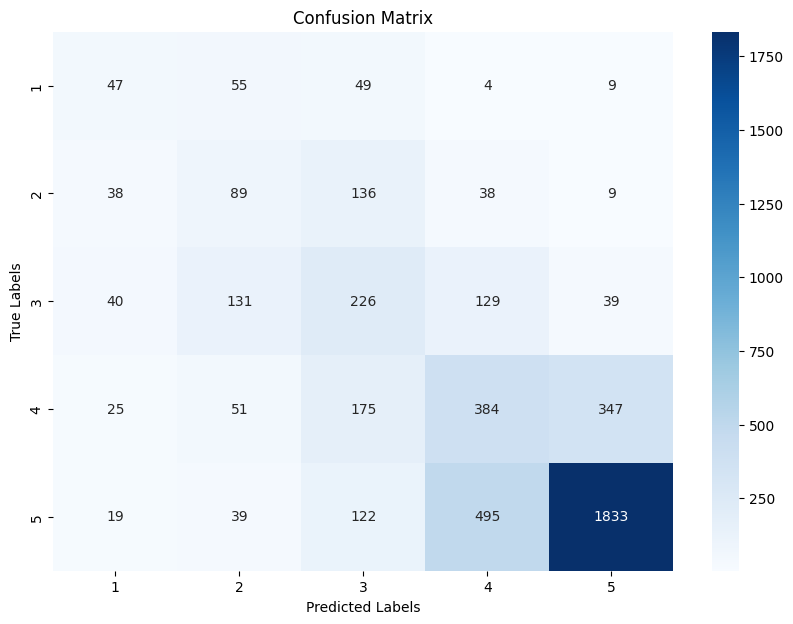

Class 1 Feature Importance:
retailer, small, size, way, just, look, ordered, really, returned, quality, disappointed, fit, fabric, looked, shirt, looks, cheap, material, like, dress
--------------------------------------------------
Class 2 Feature Importance:
huge, work, love, unfortunately, didn, material, wanted, fit, look, size, shirt, looked, way, ordered, small, really, just, fabric, like, dress
--------------------------------------------------
Class 3 Feature Importance:
beautiful, wanted, color, shirt, way, cute, material, ordered, love, didn, large, really, look, fabric, small, fit, size, just, like, dress
--------------------------------------------------
Class 4 Feature Importance:
shirt, runs, ordered, large, color, fabric, just, nice, really, bit, fit, cute, wear, small, love, like, little, great, size, dress
--------------------------------------------------
Class 5 Feature Importance:
colors, little, beautiful, jeans, small, bought, just, fits, like, color, flattering, 

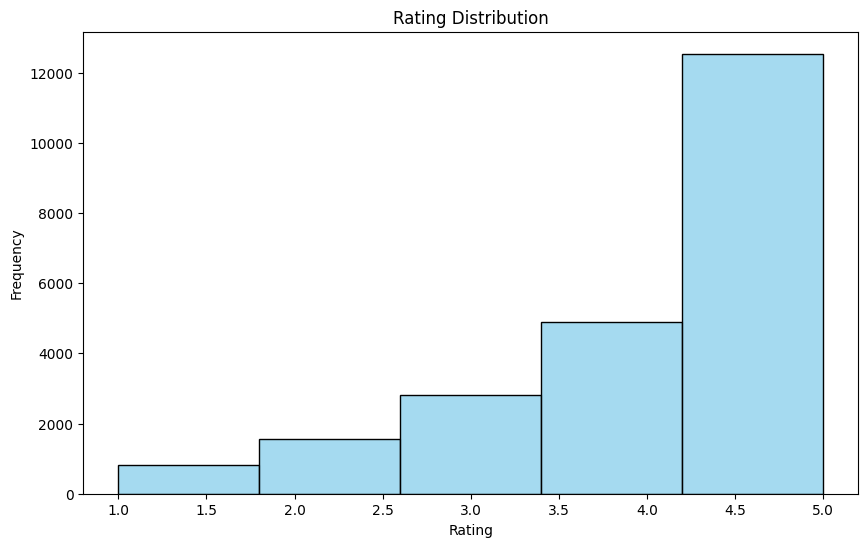

In [2]:
import tkinter as tk
from tkinter import messagebox
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Simple tkinter Frontend
class ReviewClassifierApp:
    def __init__(self, root, model, vectorizer, classes):
        self.root = root
        self.model = model
        self.vectorizer = vectorizer
        self.classes = classes

        self.root.title("Review Classifier")

        # Label for instructions
        self.instruction_label = tk.Label(root, text="Enter a review to classify:")
        self.instruction_label.pack(pady=10)

        # Entry widget for review text
        self.review_entry = tk.Entry(root, width=50)
        self.review_entry.pack(pady=10)

        # Button to classify the review
        self.classify_button = tk.Button(root, text="Classify Review", command=self.classify_review)
        self.classify_button.pack(pady=10)

        # Label for showing prediction result
        self.result_label = tk.Label(root, text="", font=("Helvetica", 14))
        self.result_label.pack(pady=20)

    def classify_review(self):
        review_text = self.review_entry.get()
        if not review_text:
            messagebox.showwarning("Input Error", "Please enter a review.")
            return

        review_vect = self.vectorizer.transform([review_text])
        predicted_class = self.model.predict(review_vect)[0]
        self.display_result(predicted_class)

    def display_result(self, predicted_class):
        # Map classes to colors
        color_map = {
            1: "red",
            2: "orange",
            3: "pink",
            4: "blue",
            5: "green"
        }

        # Update the result label with the predicted class and color
        self.result_label.config(
            text=f"Predicted Rating: {predicted_class}",
            fg=color_map.get(predicted_class, "black") # Default to black if not found
        )


# Visualization functions
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

def plot_feature_importance(vectorizer, model, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    class_indices = model.feature_log_prob_
    for i, class_probs in enumerate(class_indices):
        print(f"Class {i+1} Feature Importance:")
        top_features = np.argsort(class_probs)[-top_n:]
        print(", ".join([feature_names[j] for j in top_features]))
        print("-" * 50)

def plot_histograms(df):
    plt.figure(figsize=(10, 6))
    
    # Ensure that 'Rating' is numeric, else filter the rows with non-numeric ratings
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df = df.dropna(subset=['Rating'])  # Drop rows where 'Rating' is NaN after conversion
    
    # Plot the histogram
    sns.histplot(df['Rating'], kde=False, bins=len(df['Rating'].unique()), color='skyblue')
    plt.title("Rating Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.show()

def main():
    # Load and preprocess data
    nltk.download('punkt')  # For tokenization

    fields = ["Title", "Review Text", "Rating"]
    file_path = 'reviewdataset.csv'  # Replace with your file path
    if not os.path.exists(file_path):
        print("Error: File not found.")
        return

    df = pd.read_csv(file_path, usecols=fields)

    print("Preprocessing...")

    toDelete = []
    for i in range(len(df)):
        entry = df.iloc[i]
        if pd.isna(entry["Title"]) and pd.isna(entry["Review Text"]):
            toDelete.append(i)
        elif pd.isna(entry["Review Text"]):
            df.at[i, "Review Text"] = entry["Title"]

    df = df.drop(toDelete)
    df = df.reset_index()

    # Lowercase the review text
    for i in range(0, len(df)):
        df.at[i, "Review Text"] = df.at[i, "Review Text"].lower()

    # Split the dataset
    review = df["Review Text"]
    rating = df["Rating"]
    review, reviewTest, rating, ratingTest = train_test_split(review, rating, stratify=rating, test_size=0.2, random_state=42)

    df2 = {"Review Text": review.tolist(), "Rating": rating.tolist()}
    df2 = pd.DataFrame(df2)

    # Convert text to numeric vectors using TF-IDF (or CountVectorizer)
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))  # Using TF-IDF and bigrams
    X = vectorizer.fit_transform(review.tolist())  # Convert review text to 2D array of features
    y = rating.tolist()  # Labels (ratings)

    # Balance the training set using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Train the model using sklearn's Multinomial Naive Bayes
    print("Training...")

    start_time = time.time()

    model = MultinomialNB()
    model.fit(X_resampled, y_resampled)

    print(f"Training took {time.time() - start_time:.2f} seconds")

    print("Evaluating on Test Data...")

    # Predict on test data
    reviewTest_vect = vectorizer.transform(reviewTest)
    predicted_test = model.predict(reviewTest_vect)

    # Calculate metrics
    accuracy = accuracy_score(ratingTest, predicted_test)
    precision = precision_score(ratingTest, predicted_test, average='weighted')
    recall = recall_score(ratingTest, predicted_test, average='weighted')
    f1 = f1_score(ratingTest, predicted_test, average='weighted')
    conf_matrix = confusion_matrix(ratingTest, predicted_test)

    # Print results
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Visualizations
    plot_confusion_matrix(conf_matrix, sorted(set(ratingTest)))
    plot_feature_importance(vectorizer, model)
    plot_histograms(df)

    # Start the Tkinter app
    root = tk.Tk()
    app = ReviewClassifierApp(root, model, vectorizer, set(rating))
    root.mainloop()


if __name__ == "__main__":
    main()
